# https://www.kaggle.com/c/tt-GameLevel/data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv')
df.head()

,Unnamed: 0,player_0,player_1,player_2,player_3,player_4,level_0,level_1,level_2,level_3,level_4,level_5,age,duration_ms,# tries,target
0,5204,0.025087,0.029495,3.361538e-06,0.007414,1.915486,0.002375,0.472284,0.021519,0.503860,11.0,1.0,15.0,215793.8,15,5
1,5175,0.024538,0.016962,2.842308e-06,0.004231,1.967912,0.001115,0.541616,0.005808,0.557895,NaN,0.0,20.0,271493.0,1,8
2,638,0.018192,0.017910,0.000000e+00,0.003359,1.953176,0.001296,0.456985,0.016872,0.596491,6.0,1.0,21.0,240264.0,6,3
3,6733,0.020673,0.020808,1.780798e-02,0.006423,1.998824,0.001202,0.507592,0.009712,0.615789,9.0,1.0,17.0,277560.5,4,8
4,2706,0.026192,0.032269,3.923077e-08,0.001815,2.108529,0.001269,0.489113,0.024154,0.410526,NaN,0.0,15.0,260773.0,1,9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7551 entries, 0 to 7550
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7551 non-null   int64  
 1   player_0     7551 non-null   float64
 2   player_1     7551 non-null   float64
 3   player_2     7551 non-null   float64
 4   player_3     7551 non-null   float64
 5   player_4     7551 non-null   float64
 6   level_0      7077 non-null   float64
 7   level_1      7043 non-null   float64
 8   level_2      6791 non-null   float64
 9   level_3      7277 non-null   float64
 10  level_4      6732 non-null   float64
 11  level_5      6967 non-null   float64
 12  age          5300 non-null   float64
 13  duration_ms  7551 non-null   float64
 14  # tries      7551 non-null   int64  
 15  target       7551 non-null   int64  
dtypes: float64(13), int64(3)
memory usage: 944.0 KB


- player_XXX - anonymized player metadata (how much overall time player spent in the game? how much points player collected? etc.)
- level_XXX - anonymized gameplay metadata (how much points player collected during this level? how much HP player lost during this level? etc.)
- age - age of the player (years)
- duration_ms - duration of the last (successful) try
- tries - number of tries it took to finish this level

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def fill_missed_values(original_data):
    
    new_data = original_data.copy()

    cols_with_missing = (col for col in new_data.columns 
                                     if new_data[col].isnull().any())
    for col in cols_with_missing:
        new_data[col + '_was_missing'] = new_data[col].isnull()
    real_columns = new_data.columns
    
    imputer = IterativeImputer(max_iter=10, initial_strategy='mean', random_state=42)
    new_data = pd.DataFrame(imputer.fit_transform(new_data))
    new_data.columns = real_columns
    
    return new_data

In [5]:
from sklearn.preprocessing import StandardScaler

df.duration_ms = StandardScaler().fit_transform(df.duration_ms.values.reshape(-1,1))
df = fill_missed_values(df)

features = ['level_4', 'level_5', 'age', '# tries', 'target', 'level_0_was_missing',
            'level_1_was_missing', 'level_2_was_missing', 'level_3_was_missing', 
            'level_4_was_missing', 'level_5_was_missing', 'age_was_missing']

for feature in features:
    df[feature] = df[feature].astype(np.int64)

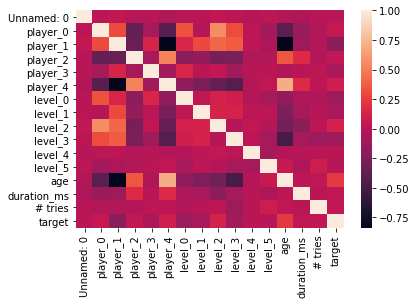

In [6]:
sns.heatmap(df.iloc[:, :16].corr())

# Modeling

In [7]:
from sklearn.metrics import f1_score, confusion_matrix

In [8]:
X = df.drop(['Unnamed: 0', 'target'], axis=1)
y = df.target

## KMeans 5

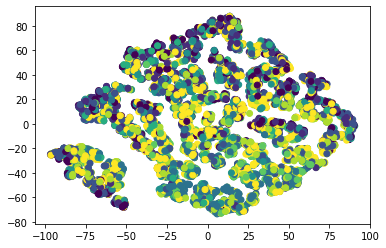

In [9]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X.iloc[:, :16])
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, max_iter=500, random_state=42, n_jobs=-1)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [11]:
%%time
kmeans.fit(X)
y_pred = kmeans.predict(X)

CPU times: user 512 ms, sys: 43.9 ms, total: 556 ms
Wall time: 1.58 s


In [12]:
y_pred = [x+1 for x in y_pred]

0.1253634545376698


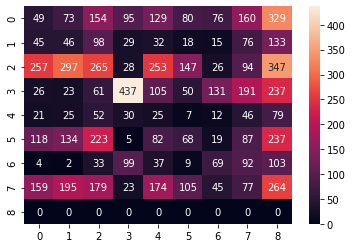

In [13]:
print(f1_score(y, y_pred, average='macro'))
sns.heatmap(confusion_matrix(y_pred, y), annot=True, fmt="d")